In [77]:

import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from matplotlib import pyplot as plt

input_size = 1  # 输入变量的维度，一维
batch_size = 1
hidden_size = 64
num_layers = 3
output_size = 1

In [78]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.rnn = nn.RNN(
            input_size=input_size,    # feature_len = 1
            hidden_size=hidden_size,  # 隐藏记忆单元个数hidden_len = 16
            num_layers=num_layers,    # 网络层数 = 1
            batch_first=True,         # 在传入数据时,按照[batch,seq_len,feature_len]的格式
        )
        

        for p in self.rnn.parameters():  # 对RNN层的参数做初始化
            nn.init.normal_(p, mean=0.0, std=0.001)

        self.linear = nn.Linear(hidden_size, output_size)  # 输出层

    def forward(self, x, hidden_prev):
        """
        x：一次性输入所有样本所有时刻的值(batch,seq_len,feature_len)
        hidden_prev：第一个时刻空间上所有层的记忆单元(batch, num_layer, hidden_len)
        输出out(batch,seq_len,hidden_len) 和 hidden_prev(batch,num_layer,hidden_len)
        """
        
        # print("x",x.shape)
        # print("hidden_prev_1",hidden_prev)
        # print("hidden_prev_1",hidden_prev.shape)
        out, hidden_prev = self.rnn(x, hidden_prev) #out hn
        # print("hidden_prev_2",hidden_prev)
        # print("hidden_prev_2",hidden_prev.shape)
        # print("out",out)
        # print("out",out.shape)
        '''
        out的最后一维输出等于hn
        '''
        # print(out.shape)  # [49, 16]，49个点49个输出一次h0-h49
        # 因为要把输出传给线性层处理，这里将batch和seq_len维度打平
        # 再把batch=1添加到最前面的维度（为了和y做MSE）
        # [batch=1,seq_len,hidden_len]->[seq_len,hidden_len]
        out = out.view(-1, hidden_size)

        # [seq_len,hidden_len]->[seq_len,output_size=1]
        out = self.linear(out)
        # [seq_len,output_size=1]->[batch=1,seq_len,output_size=1]
        out = out.unsqueeze(dim=0)
        return out, hidden_prev


In [79]:
# 初始化记忆单元h0[num_layers, batch_size, hidden_size]
hidden_prev = torch.zeros(num_layers, batch_size, hidden_size)
model = Net()

In [118]:
# 训练过程
learning_rate = 0.000001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_time_steps = 50  # 区间内取多少样本点

In [119]:
for iter in range(400):    
    # 在0~3之间随机取开始的时刻点
    # start = np.random.randint(3, size=1)[0]
    start = 1
    # 在[start,start+10]区间均匀地取num_points个点
    time_steps = np.linspace(start, start + 10, num_time_steps)
    data = np.sin(time_steps)
    # print(data.shape)
    # [num_time_steps,] -> [num_points,1]
    data = data.reshape(num_time_steps, 1)
    # print(data.shape)
    # 输入前49个点(seq_len=49)，即下标0~48 [batch, seq_len, feature_len]
    x = torch.tensor(data[:-1]).float().view(1, num_time_steps - 1, 1)
    # 预测后49个点，即下标1~49
    y = torch.tensor(data[1:]).float().view(1, num_time_steps - 1, 1)
    # 以上步骤生成(x,y)数据对
    # print(x.shape,y.shape)


    output, hidden_prev = model(x, hidden_prev)  # 喂入模型得到输出
    # print(f'model_put \t {output.shape}{hidden_prev.shape}')
    hidden_prev = hidden_prev.detach()  # 或着hidden_prev.data
    # print("hidden_prev_detach",hidden_prev.shape)
    loss = criterion(output, y)  # 计算MSE损失
    model.zero_grad()
    loss.backward()
    optimizer.step()
    if iter % 1 == 0:
            print("Iteration: {} loss {}".format(iter, loss.item()))

Iteration: 0 loss 6.272833707043901e-05
Iteration: 1 loss 9.790615877136588e-06
Iteration: 2 loss 1.0062365618068725e-05
Iteration: 3 loss 1.0329373253625818e-05
Iteration: 4 loss 1.055410029948689e-05
Iteration: 5 loss 1.0721869330154732e-05
Iteration: 6 loss 1.0828012818819843e-05
Iteration: 7 loss 1.087441069103079e-05
Iteration: 8 loss 1.0867059245356359e-05
Iteration: 9 loss 1.081515074474737e-05
Iteration: 10 loss 1.0727560038503725e-05
Iteration: 11 loss 1.0614877282932866e-05
Iteration: 12 loss 1.0486306564416736e-05
Iteration: 13 loss 1.0352010576752946e-05
Iteration: 14 loss 1.0219031537417322e-05
Iteration: 15 loss 1.0093734999827575e-05
Iteration: 16 loss 9.98199266177835e-06
Iteration: 17 loss 9.886779480439145e-06
Iteration: 18 loss 9.810137271415442e-06
Iteration: 19 loss 9.752878213475924e-06
Iteration: 20 loss 9.71378085523611e-06
Iteration: 21 loss 9.690852493804414e-06
Iteration: 22 loss 9.682177733338904e-06
Iteration: 23 loss 9.68420772551326e-06
Iteration: 24 loss

In [123]:
# 测试过程
# 先用同样的方式生成一组数据x,y
# start = np.random.randint(3, size=1)[0]
start = 1
time_steps = np.linspace(start, start + 10, num_time_steps)
data = np.sin(time_steps)
data = data.reshape(num_time_steps, 1)
x = torch.tensor(data[:-1]).float().view(1, num_time_steps - 1, 1)
y = torch.tensor(data[1:]).float().view(1, num_time_steps - 1, 1)
print(x.shape,y.shape)

torch.Size([1, 49, 1]) torch.Size([1, 49, 1])


In [124]:
predictions = []

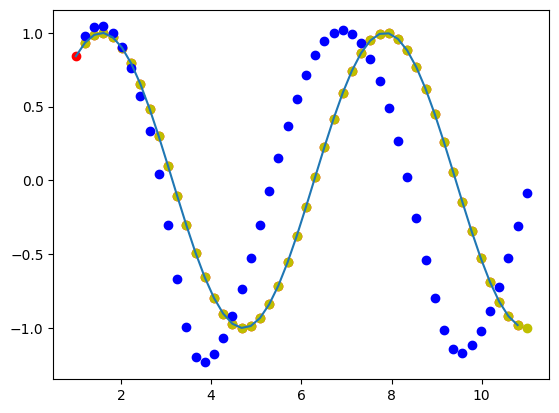

In [125]:
input = x[:, 0, :]           # 取seq_len里面第0号数据
# print(input.shape)
input = input.view(1, 1, 1)  # input：[1,1,1]
# print(input.shape)
for _ in range(x.shape[1]):

    pred, hidden_prev = model(input, hidden_prev)
    # print(pred, hidden_prev)
    # print(f'model_put \t {pred.shape}{hidden_prev.shape}')
    input = pred
    predictions.append(pred.detach().numpy().ravel()[0])
    # print(pred.detach().numpy().ravel()[0])
x = x.data.numpy()
y = y.data.numpy()
plt.plot(time_steps[:-1], x.ravel())
plt.scatter(time_steps[:-1], x.ravel(), c='r')  # x值
plt.scatter(time_steps[1:], y.ravel(), c='y')  # y值
plt.scatter(time_steps[1:], predictions, c='b')  # y的预测值


plt.show()